In [1]:
# 0 各种import
import numpy as np
import h5py
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # 设定图片的默认尺寸
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
%load_ext autoreload
%autoreload 2
np.random.seed(1)

D:\Anaconda\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# 定义要用到的方法
def sigmoid(Z):
    """
    使用numpy实现sigmoid函数
    Arguments:
    Z -- 任何尺寸的numpy array
    Returns:
    A -- 输出sigmoid(z), 形状和Z一样
    cache -- 就是Z，在反向传播中会用到
    """
    A = 1/(1+np.exp(-Z))
    cache = Z
    return A, cache


def relu(Z):
    """
    使用numpy实现relu函数
    Arguments:
    Z -- 任何尺寸的numpy array
    Returns:
    A -- 输出relu(z), 形状和Z一样
    cache -- 就是Z，在反向传播中会用到
    """
    A = np.maximum(0,Z)
    assert(A.shape == Z.shape)
    cache = Z 
    return A, cache


def relu_backward(dA, cache):
    """
    实现了relu单元的反向传播
    Arguments:
    dA -- 激活函数的梯度
    cache -- 之前定义的relu函数中的返回值，前向传播之前的Z
    Returns:
    dZ -- 损失函数对Z的梯度
    """
    Z = cache
    dZ = np.array(dA, copy=True) # relu导数为1(输入大于0)，所以直接直接复制一份dA即可
    dZ[Z <= 0] = 0 # 当输入小于0时，relu导数为0，所以dZ中小于0的数变为0
    assert (dZ.shape == Z.shape)
    return dZ


def sigmoid_backward(dA, cache):
    """
     实现了sigmoid单元的反向传播
    Arguments:
    dA -- 激活函数的梯度
    cache -- 之前定义的sigmoid函数中的返回值，前向传播之前的Z
    Returns:
    dZ -- 损失函数对Z的梯度
    """
    Z = cache
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s) # dA乘sigmoid导数
    assert (dZ.shape == Z.shape)
    return dZ


def load_data():
    """
    读取数据
    """
    train_dataset = h5py.File('datasets/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"]) # 训练样本 shape:(209, 64, 64, 3)
    train_set_y_orig = np.array(train_dataset["train_set_y"]) # 训练样本标签 shape:(1, 209)
    
    test_dataset = h5py.File('datasets/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"]) # 测试样本 shape:(50, 64, 64, 3)
    test_set_y_orig = np.array(test_dataset["test_set_y"]) # 测试样本标签 shape:(1, 50)
    
    classes = np.array(test_dataset["list_classes"][:]) # 标签类别(一共两类：是猫、不是猫)
    
    train_set_y_orig = train_set_y_orig.reshape((1, -1)) # 确保标签是一行数据 下同
    test_set_y_orig = test_set_y_orig.reshape((1, -1))
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [3]:
# 把数据弄下来
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

# 瞅一瞅你的数据
m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_test = test_x_orig.shape[0]
print ("训练集样本数量: " + str(m_train))
print ("测试集样本数量: " + str(m_test))
print ("每个图片的尺寸(最后的3是RGB三色通道): (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_x_orig shape: " + str(train_x_orig.shape))
print ("train_y shape: " + str(train_y.shape))
print ("test_x_orig shape: " + str(test_x_orig.shape))
print ("test_y shape: " + str(test_y.shape))

训练集样本数量: 209
测试集样本数量: 50
每个图片的尺寸(最后的3是RGB三色通道): (64, 64, 3)
train_x_orig shape: (209, 64, 64, 3)
train_y shape: (1, 209)
test_x_orig shape: (50, 64, 64, 3)
test_y shape: (1, 50)


In [4]:
# 改变训练集和测试集的shape
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# 标准化数据，使其值为0到1之间
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.
print ("train_x shape: " + str(train_x.shape))
print ("test_x shape: " + str(test_x.shape))

train_x shape: (12288, 209)
test_x shape: (12288, 50)


In [5]:
# 给定神经网络的层数和每层的节点数
layers_dims = [12288, 20, 7, 5, 1] #  5-layer model

In [6]:
# 1 初始化权重
def initialize_parameters_deep(layer_dims):
    """
    Arguments:
    layer_dims -- 数组或集合，表示每一层的节点数量。
    Returns:
    parameters --  字典，包含"W1", "b1", ..., "WL", "bL":
                    Wl -- 权重矩阵，其shape为 (layer_dims[l], layer_dims[l-1])
                    bl -- 变差向量，其shape为 (layer_dims[l], 1)                    
    """
    np.random.seed(3)
    parameters = {}
    L = len(layer_dims) # 网络层数
    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l] ,layer_dims[l-1]) / np.sqrt(layer_dims[l-1])#  *0.01 
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))
    return parameters

In [7]:
# 2.1 前向传播的线性部分
def linear_forward(A, W, b):
    """
    实现一层的前向传播的线性部分。
    Arguments:
    A -- 前一层的激活值(或者输入的数据)，其shape为(前一层的节点数, 样本数)
    W -- 权重矩阵，其shape为(当前层的节点数，前一层的节点数)
    b -- 偏差向量，其shape为(当前层的节点数，样本数)
    Returns:
    Z -- 激活函数的输入值
    cache -- 字典，包含"A", "W", "b"; 存储这些值以供后向传播使用。
    """
    Z = np.dot(W, A) + b
    assert(Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)
    return Z, cache

In [8]:
# 2.2 前向传播的线性激活部分
def linear_activation_forward(A_prev, W, b, activation):
    """
    实现前向传播的线性-激活部分
    Arguments:
    A_prev -- 前一层的激活值(或输入数据)，其shape为(前一层的节点数，样本数)
    W -- 权重矩阵，其shape为(当前层的节点数，前一层的节点数)
    b -- 偏差向量，其shape为(当前层的节点数，样本数)
    activation -- 在这一层要用的激活函数，是字符串格式："sigmoid" 或者 "relu" 等
    Returns:
    A -- 激活函数的输出值
    cache -- 字典，包含"linear_cache" 和 "activation_cache"; 存储这些值以供后向传播使用。
            "linear_cache"是linear_forward方法的返回值，包含"A", "W", "b"
            "activation_cache"是本方法的返回值，其值为激活函数("sigmoid" 或者 "relu" 等)
    """
    if activation == "sigmoid":
        # 输入: "A_prev, W, b". 输出: "A, activation_cache".
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
    elif activation == "relu":
        # 输入: "A_prev, W, b". 输出: "A, activation_cache".
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)
    return A, cache

In [9]:
# 2.3 前向传播
def L_model_forward(X, parameters):
    """
    实现前向传播
    Arguments:
    X -- 数据，其shape为(输入数据size，样本数)
    parameters -- initialize_parameters_deep()方法输出的值，
                    字典，包含"W1", "b1", ..., "WL", "bL":
    Returns:
    AL -- 最后的激活函数输出值
    caches -- 包含: 每一个linear_relu_forward()的cache (有L-1个, 索引从 0 到 L-2)
                   linear_sigmoid_forward()的cache (只有1个, 索引为 L-1)
    """
    caches = []
    A = X
    L = len(parameters) // 2  # 神经网络的层数
    # 实现(L-1)次线性-rulu，并将cache添加到caches中
    for l in range(1, L):
        A_prev = A 
        A, cache = linear_activation_forward(A_prev, parameters["W"+str(l)], parameters["b"+str(l)], activation = "relu")
        caches.append(cache)
    # 实现最后的这一次 线性-sigmoid，并将cache添加到caches中 （这里的sigmoid作用是将结果转换到0~1之间，输出作为概率）
    AL, cache = linear_activation_forward(A, parameters["W"+str(L)], parameters["b"+str(L)], activation = "sigmoid")
    caches.append(cache)
    assert(AL.shape == (1,X.shape[1]))
    return AL, caches

In [10]:
# 3 代价函数的计算
def compute_cost(AL, Y):
    """
    计算上面的代价函数
    Arguments:
    AL -- 是一个向量，每个值代表该样本的几率，shape为(1，样本数)
    Y -- 真实值向量，shape为(1，样本数)
    Returns:
    cost -- 交叉熵
    """
    m = Y.shape[1]
    #  用AL和y计算cost
    cost = -1/m * np.sum(Y*np.log(AL) + (1-Y)*np.log(1-AL))
    cost = np.squeeze(cost) # 确保cost的shape是你想要的 (会把比如 [[17]] 变成 17).
    assert(cost.shape == ())
    return cost

In [11]:
# 4.1 后向传播的线性部分
def linear_backward(dZ, cache):
    """
    实现一层的后向传播的线性部分
    Arguments:
    dZ --当前层的线性导数(导数全是cost的导数)
    cache -- 元组(A_prev, W, b)，由前向传播过程的当前层得来
    Returns:
    dA_prev -- 前一层的激活函数的导数，其shape和A_prev一样
    dW -- 当前层 W 的导数，其shape和 W 一样
    db -- 当前层 b 的导数，其shape和 b 一样
    """
    A_prev, W, b = cache
    m = A_prev.shape[1]
    dW = 1/m * np.dot(dZ, A_prev.T)
    db = 1/m * np.sum(dZ, axis = 1, keepdims = True)
    dA_prev = np.dot(W.T, dZ)
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    return dA_prev, dW, db

In [12]:
# 4.2 后向传播的线性激活部分  
def linear_activation_backward(dA, cache, activation):
    """
    实现一层的后向传播的线性和激活函数部分
    Arguments:
    dA -- 当前层激活函数的导数
    cache -- 元组：(linear_cache, activation_cache)，前向传播时存的
    activation -- 这层要用的激活函数，string值: "sigmoid" 或者 "relu"
    Returns:
    dA_prev -- 前一层的激活函数的导数，其shape和A_prev一样
    dW -- 当前层 W 的导数，其shape和 W 一样
    db -- 当前层 b 的导数，其shape和 b 一样
    """
    linear_cache, activation_cache = cache
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    return dA_prev, dW, db

In [13]:
# 4.3 后向传播
def L_model_backward(AL, Y, caches):
    """
    实现后向传播： (L-1) 次 [LINEAR->RELU] 和 1 次 LINEAR->SIGMOID
    Arguments:
    AL -- 是一个向量，每个值代表该样本的几率，(来自L_model_forward())
    Y -- 真实值向量(不是猫 0 , 是猫 1 )
    caches -- 包含:
                前向传播时存下来的数据：caches[0 ~ L-2]是relu部分 caches[L-1]是sigmoid部分
                caches[l]具体包括：[线性cache[A, W, b],激活cache[Z]]
    Returns:
    grads -- 一个用来存储导数的字典：
             grads["dA" + str(l)] = ...
             grads["dW" + str(l)] = ...
             grads["db" + str(l)] = ...
    """
    grads = {}
    L = len(caches) # 神经网络的层数
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # 这行之后，Y 的shape就和 AL 一样了
    
    # 初始化后向传播，该值为损失函数对预测值AL求导的结果(Y是真实值)
    dAL =  - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL)) 
    
    # 第L层 (SIGMOID -> LINEAR) 的导数. 
    # 输入: "AL, Y, caches". 
    # 输出: "grads["dAL"], grads["dWL"], grads["dbL"]
    current_cache = caches[L-1]
    grads["dA" + str(L)], grads["dW" + str(L)], grads["db" + str(L)] =  linear_activation_backward(dAL, current_cache, activation = "sigmoid")
    for l in reversed(range(L - 1)):
        # 第l层: (RELU -> LINEAR) 的导数.
        # 输入: "grads["dA" + str(l + 2)], caches". 
        # 输出: "grads["dA" + str(l + 1)] , grads["dW" + str(l + 1)] , grads["db" + str(l + 1)] 
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 2)], current_cache, activation = "relu")
        grads["dA" + str(l + 1)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp
    return grads

In [14]:
# 5 更新参数
def update_parameters(parameters, grads, learning_rate):
    """
    用梯度下降法更新参数
    Arguments:
    parameters -- 字典，包含参数
    grads -- 字典，包含导数，由L_model_backward方法得到
    Returns:
    parameters --字典，包含更新了的参数
                  parameters["W" + str(l)] = ... 
                  parameters["b" + str(l)] = ...
    """
    L = len(parameters) // 2 # 神经网络的层数
    # 更新每一个参数
    for l in range(L):
        parameters["W" + str(l+1)] -= learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] -= learning_rate * grads["db" + str(l+1)]
    return parameters

In [15]:
# 6 预测
def predict(X, y, parameters):
    """
    Arguments:
    X -- 输入数据 
    parameters -- 训练好的模型的参数
    Returns:
    p -- 对给定X的预测
    """
    m = X.shape[1] # 样本数量
    n = len(parameters) // 2 # 神经网络的层数
    p = np.zeros((1,m))
    # 前向传播
    probas, caches = L_model_forward(X, parameters)
    # 把估计值(0~1之间)转化为0或者1
    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:  # 因为结果shape是(1,样本数)，是个矩阵，所以不能直接probas[i]
            p[0,i] = 1
        else:
            p[0,i] = 0
    print("Accuracy: "  + str(np.sum((p == y)/m)))
    return p

In [16]:
# final：神经网络！
def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):#lr was 0.009
    """
    实现一个L层的神经网络: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    Arguments:
    X -- 数据，shape为 (样本数, 像素 * 像素 * 3)
    Y -- 真实值向量 (是猫：1，不是猫：0),shape为 (1, 样本数)
    layers_dims -- 包含每一层的节点数
    learning_rate -- 梯度下降更新的速率
    num_iterations -- 迭代次数
    print_cost -- 如果置为True，每迭代100次就输出一次cost
    Returns:
    parameters -- 由此模型学习到的参数，可以用它们去做预测
    """
    np.random.seed(1)
    costs = []                         # keep track of cost
    # 1 参数初始化
    parameters = initialize_parameters_deep(layers_dims)
    # 梯度下降循环
    for i in range(0, num_iterations):
        # 2 前向传播: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        AL, caches =  L_model_forward(X, parameters)
        # 3 计算cost.
        cost = compute_cost(AL, Y)
        # 4 后向传播
        grads = L_model_backward(AL, Y, caches)
        # 5 更新参数
        parameters = update_parameters(parameters, grads, learning_rate)
        # 每迭代100次就输出一次cost
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
    # 画出cost曲线
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    return parameters

Cost after iteration 0: 0.715732
Cost after iteration 100: 0.674738
Cost after iteration 200: 0.660337
Cost after iteration 300: 0.646289
Cost after iteration 400: 0.629813
Cost after iteration 500: 0.606006
Cost after iteration 600: 0.569004
Cost after iteration 700: 0.519797
Cost after iteration 800: 0.464157
Cost after iteration 900: 0.408420
Cost after iteration 1000: 0.373155
Cost after iteration 1100: 0.305724
Cost after iteration 1200: 0.268102
Cost after iteration 1300: 0.238725
Cost after iteration 1400: 0.206323
Cost after iteration 1500: 0.179439
Cost after iteration 1600: 0.157987
Cost after iteration 1700: 0.142404
Cost after iteration 1800: 0.128652
Cost after iteration 1900: 0.112443
Cost after iteration 2000: 0.085056
Cost after iteration 2100: 0.057584
Cost after iteration 2200: 0.044568
Cost after iteration 2300: 0.038083
Cost after iteration 2400: 0.034411


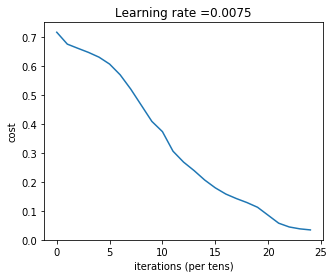

In [17]:
# 训练参数
parameters = L_layer_model(train_x, train_y, layers_dims, num_iterations = 2500, print_cost = True)

In [18]:
# 去预测训练集
pred_train = predict(train_x, train_y, parameters)

Accuracy: 0.9952153110047844


In [19]:
# 去预测测试集
pred_test = predict(test_x, test_y, parameters)

Accuracy: 0.78
